## 1. Import Library

In [1]:
# Import library
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

## 2.  Load Dataset

In [2]:
# Load data
# Colab library to upload files to notebook, Ref:https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# Load data from Kaggle to Google Colab virtual machine
os.environ['KAGGLE_USERNAME'] = "emilyhsucr" # username from the json file
os.environ['KAGGLE_KEY'] = "3b6aa5aa02b468c89e4cfac52a5d992e" # key from the json file
!kaggle datasets download -d ahmedmoorsy/facial-expression # api copied from kaggle

 96% 186M/193M [00:03<00:00, 54.8MB/s]
100% 193M/193M [00:03<00:00, 57.5MB/s]


In [0]:
!unzip -q "facial-expression.zip"

In [4]:
#fer2013
# Facial Expression Detection (CNN), Ref: https://www.kaggle.com/shawon10/facial-expression-detection-cnn
filename = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']

fer2013 = pd.read_csv('fer2013.csv')
im=fer2013['pixels']
fer2013.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
def getData(filename):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [6]:
X, Y = getData(filename)
num_class = len(set(Y))
print(num_class)

7


In [0]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

## 3. Build the network

In [9]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


### LeNet-5 layers
- Convolution #1. Input = 32x32x1. Output = 28x28x6 conv2d
- SubSampling #1. Input = 28x28x6. Output = 14x14x6. SubSampling is simply - Average Pooling so we use avg_pool
- Convolution #2. Input = 14x14x6. Output = 10x10x16 conv2d
- SubSampling #2. Input = 10x10x16. Output = 5x5x16 avg_pool
- Fully Connected #1. Input = 5x5x16. Output = 120
- Fully Connected #2. Input = 120. Output = 84
- Output 10

Ref:https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086

https://github.com/TaavishThaman/LeNet-5-with-Keras/blob/master/lenet_5.py

In [10]:
def my_model():

    model = Sequential()
    #Layer 1
    #Conv Layer 1
    model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (48,48,1)))
    #Pooling layer 1
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    #Layer 2
    #Conv Layer 2
    model.add(Conv2D(filters = 16,
                     kernel_size = 5,
                     strides = 1,
                     activation = 'relu',
                     input_shape = (14,14,6)))
    #Pooling Layer 2
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    #Flatten
    model.add(Flatten())
    #Layer 3
    #Fully connected layer 1
    model.add(Dense(units = 120, activation = 'relu'))
    #Layer 4
    #Fully connected layer 2
    model.add(Dense(units = 84, activation = 'relu'))
    #Layer 5
    #Output Layer
    model.add(Dense(units = 7, activation = 'softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model
model=my_model()
model.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               155640    
_________________________________________________________________
dense_2 (Dense)              (None, 84)         

In [30]:
path_model='model_filter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-4) # set the learning rate
# fit the model
history =model.fit(x=X_train,     
            y=y_train, 
            epochs=50, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 32298 samples, validate on 3589 samples
Epoch 1/50
32298/32298 [==============================] - 6s 184us/step - loss: 1.7712 - acc: 0.2782 - val_loss: 1.6766 - val_acc: 0.3644
Epoch 2/50
32298/32298 [==============================] - 6s 170us/step - loss: 1.6357 - acc: 0.3696 - val_loss: 1.5991 - val_acc: 0.4085
Epoch 3/50
32298/32298 [==============================] - 6s 171us/step - loss: 1.5747 - acc: 0.3993 - val_loss: 1.5441 - val_acc: 0.4185
Epoch 4/50
32298/32298 [==============================] - 6s 178us/step - loss: 1.5319 - acc: 0.4151 - val_loss: 1.5154 - val_acc: 0.4335
Epoch 5/50
32298/32298 [==============================] - 6s 170us/step - loss: 1.4968 - acc: 0.4278 - val_loss: 1.4876 - val_acc: 0.4422
Epoch 6/50
32298/32298 [==============================] - 5s 166us/step - loss: 1.4659 - acc: 0.4402 - val_loss: 1.4813 - val_acc: 0.4397
Epoch 7/50
32298/32298 [==============================] - 5s 166us/step - loss: 1.4357 - acc: 0.4506 - val_loss: 1.4373 - v

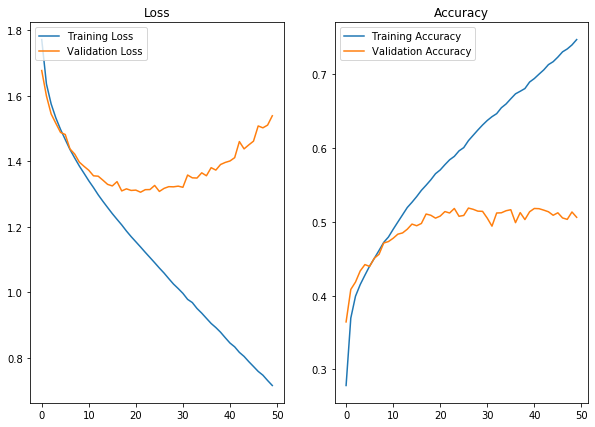

In [31]:
''' Visualize the training/validation loss and training/validation accuracy'''
from pylab import rcParams

rcParams['figure.figsize'] = 10, 7

loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

acc = history.history.get('acc')
val_acc = history.history.get('val_acc')
    
plt.figure(0)

plt.subplot(121)

plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss')


plt.subplot(122)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.show()

In [0]:
# Save model weight
model.save_weights('model_weights_LeNet5-_lr1-e4.h5') # HDF5 file

In [0]:
model.save('./model_LeNet5-_lr1-e4.t')